# Bayes推論 Programing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 問題
Iris-dataset のうち、setosa の sepal_length の Data分布が正規分布に従うという前提のもと、平均$(\mu)$ と標準偏差$(\sigma)$、２つの Parameter の確率分布を推測する。

In [2]:
# Iris-dataset の読み込み
df = sns.load_dataset('iris')
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [3]:
# species の分布確認
df['species'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

対象となる setosa は50件

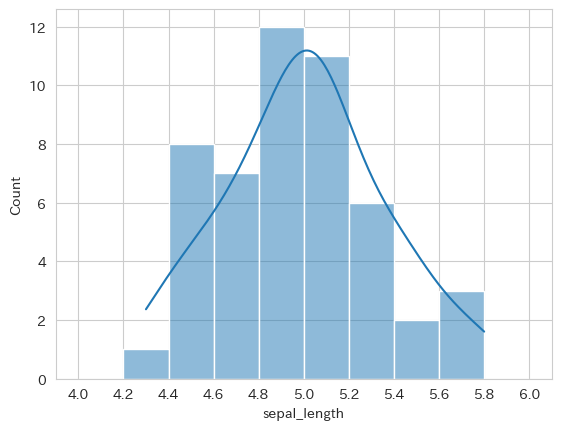

In [4]:
# setosa のみを抽出し Histogram で描画
df_setosa = df[df['species'] == 'setosa'].copy()

bins = np.arange(4.0, 6.2, 0.2)
# 描画
sns.histplot(df_setosa, x='sepal_length', bins=bins, kde=True)
plt.xticks(bins)
plt.show()

Bayes推論の結果、得られた正規分布関数と、KDE による確率密度関数の形が近いかどうかを確認していく。

In [5]:
# Bayes推論で観測値（observed）として用いる変数の抽出
sepal_lengths = df_setosa['sepal_length'].values

display(df_setosa['sepal_length'].describe())  # 統計情報の確認
display(sepal_lengths)  # 値の確認

count    50.00000
mean      5.00600
std       0.35249
min       4.30000
25%       4.80000
50%       5.00000
75%       5.20000
max       5.80000
Name: sepal_length, dtype: float64

array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
       4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
       5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
       5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. ])

### 確率 Model 定義
- 観測値 sepal_length を表現する確率分布は正規分布と前提を置いている。
- 予測対象の正規分布の Parameter $\mu$ の事前分布用確率 Model => 正規分布とする。
- 予測対象の正規分布の Parameter $\sigma$ の事前分布用確率 Model => 半正規分布とする。※ $\sigma$ が正である必要性より。
- 事前分布 Parameters は、 $\sigma = 10.0$ とする。

In [6]:
# 確率 Model 定義
model = pm.Model()

with model:
    mu = pm.Normal('mu', mu=0.0, sigma=10.0)
    sigma = pm.HalfNormal('sigma', sigma=10.0)
    sepal_lengths_obs = pm.Normal('sepal_lengths_obs', mu=mu, sigma=sigma, observed=sepal_lengths)

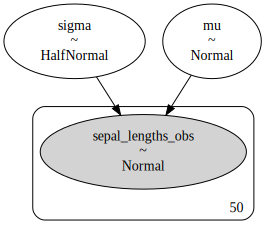

In [7]:
# 確率 Model 構造の可視化
g = pm.model_to_graphviz(model)
g

- 確率変数 `mu` の事前分布は正規分布。
- 確率変数 `sigma` の事前分布は半正規分布。
- 確率変数 `sepal_lengths_obs` の分布は正規分布に従い、`mu`, `sigma` ２つの Parameters により確率 Model が決まる。
- 確率変数 `sepal_lengths_obs` は 50個の観測値を持っている。

In [8]:
# Sampling
with model:
    idata = pm.sample(random_seed=42, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


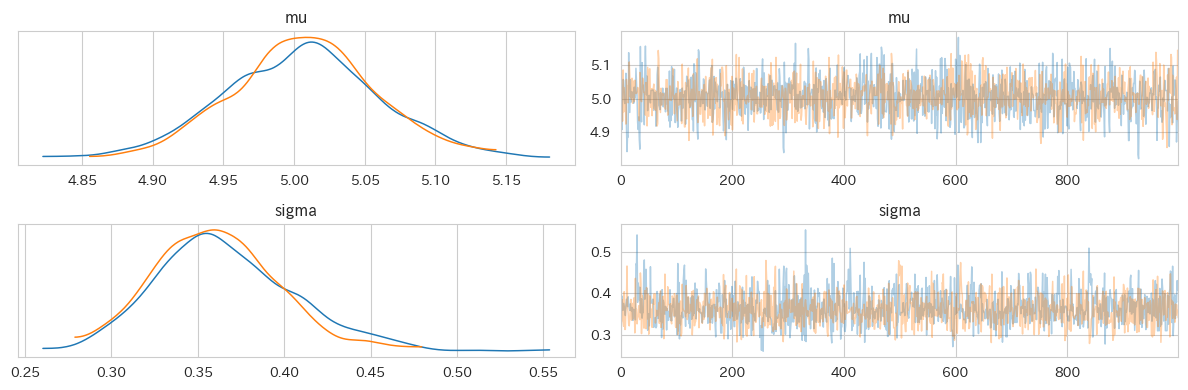

In [9]:
# Sampling の正常性を確認
az.plot_trace(idata, compact=False)
plt.tight_layout()
plt.show()

- `mu`, `sigma` ともにそれぞれの系列の形がほぼ一緒。
- 確率分布としてとり得る値の範囲もまんべんなく行き来している。

上記より、Bayes推論は、うまくいっていると判断。

In [10]:
# idata の確認
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

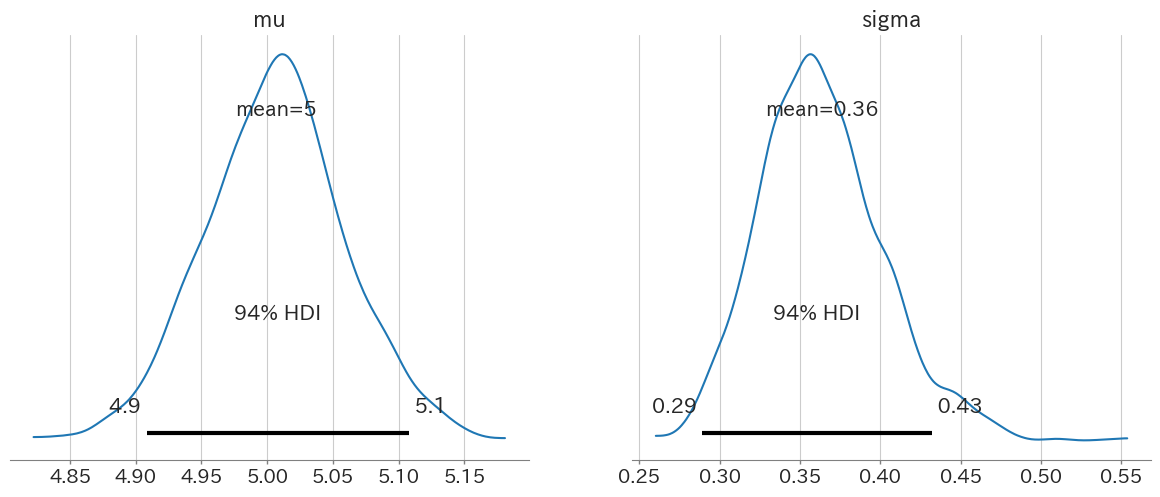

In [11]:
# Sample値の確率分布を可視化
ax = az.plot_posterior(idata)
plt.show()

In [12]:
# Sampling結果を統計分析
summary = az.summary(idata)
display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.006,0.053,4.908,5.108,0.001,0.001,1987.0,1081.0,1.00
sigma,0.364,0.038,0.289,0.432,0.001,0.001,1619.0,1201.0,1.01


- mcse_mean: 0.01以下
- ess_bulk: 400以上
- r_hat: 1.01以下

のため、Bayes推論は正常に行なわれたと判断。

Bayes推論で求めた最も確からしい Parameters の正規分布と観測値の Histogram を重ねて描画することで、当てはめの正しさを確認する。

In [13]:
# 正規分布関数の定義
def norm(x, mu, sigma):
    y = (x - mu) / sigma
    a = np.exp(-(y ** 2) / 2)
    b = np.sqrt(2 * np.pi) * sigma
    return a / b

In [14]:
# Bayes推論結果に基づく関数値計算
mu_mean = summary.loc['mu', 'mean']
sigma_mean = summary.loc['sigma', 'mean']

sepal_lengths_min = sepal_lengths.min()
sepal_lengths_max = sepal_lengths.max()

sepal_lengths_list = np.arange(sepal_lengths_min, sepal_lengths_max, 0.01)
y_list = norm(sepal_lengths_list, mu_mean, sigma_mean)

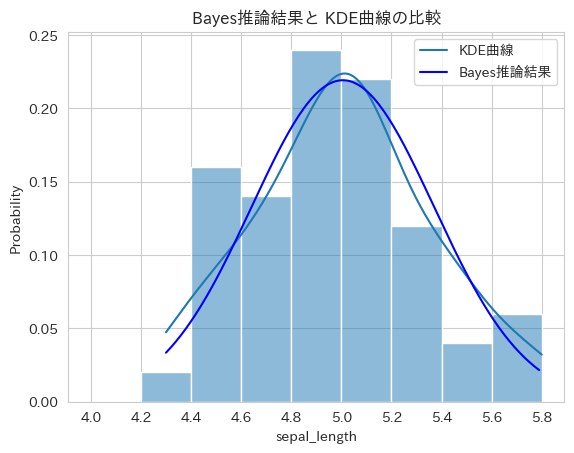

In [15]:
# Bayes推論結果に基づく正規分布関数と KDE曲線を重ねて描画
delta = 0.2
bins = np.arange(4.0, 6.0, delta)
fig, ax = plt.subplots()
sns.histplot(df_setosa, ax=ax, x='sepal_length', bins=bins, kde=True, stat='probability')
ax.get_lines()[0].set_label('KDE曲線')
ax.set_xticks(bins)
ax.plot(sepal_lengths_list, y_list * delta, c='b', label='Bayes推論結果')
ax.set_title('Bayes推論結果と KDE曲線の比較')
plt.legend()
plt.show()

KDE曲線と Bayes推論から導出した正規分布関数の Graph は非常に近い値をとっていることから適切に Bayes推論が行なわれていると判断できる。

### 少ない Sample数での Bayes推論
Bayes推論は、Sample数が少ない、統計的に厳しい条件でも比較的精度の高い推論結果を返すことができる。
Iris-dataset の同一種の花の Data を５件だけ抽出して Bayes推論を行なってみる

In [16]:
# Data の準備
sepal_lengths_less = sepal_lengths[:5]
print(sepal_lengths_less)  # 値の確認
display(df_setosa['sepal_length'][:5].describe())  # 統計値の確認

[5.1 4.9 4.7 4.6 5. ]


count    5.000000
mean     4.860000
std      0.207364
min      4.600000
25%      4.700000
50%      4.900000
75%      5.000000
max      5.100000
Name: sepal_length, dtype: float64

In [17]:
# 確率 Model 定義 & Sampling
model_less = pm.Model()
with model_less:
    mu = pm.Normal('mu', mu=0.0, sigma=10.0)
    sigma = pm.HalfNormal('sigma', sigma=10.0)
    sepal_lengths_less_obs = pm.Normal('sepal_lengths_less_obs', mu=mu, sigma=sigma, observed=sepal_lengths_less)

    # Sampling
    idata_less = pm.sample(chains=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


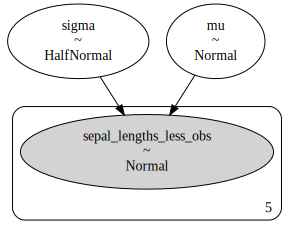

In [18]:
# 確率 Model 構造を可視化
g = pm.model_to_graphviz(model_less)
g

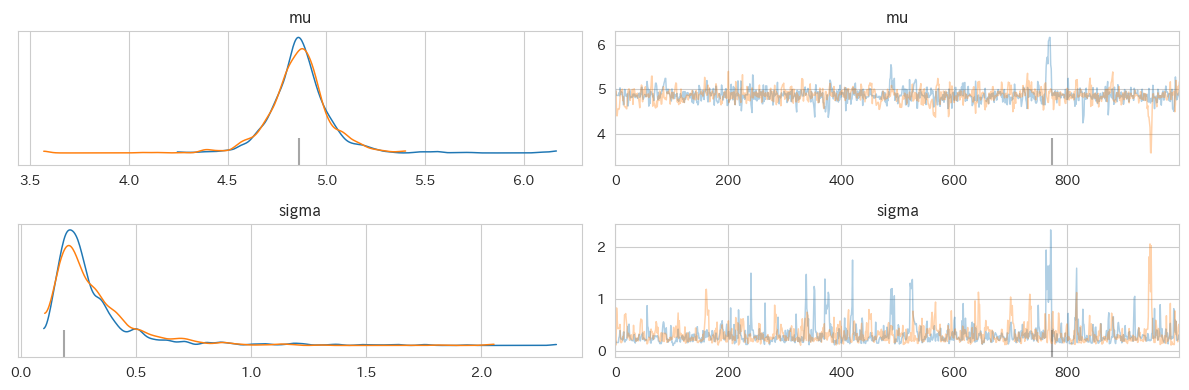

In [19]:
# Bayes推論の正常性の確認
ax = az.plot_trace(idata_less, compact=False)
plt.tight_layout()
plt.show()

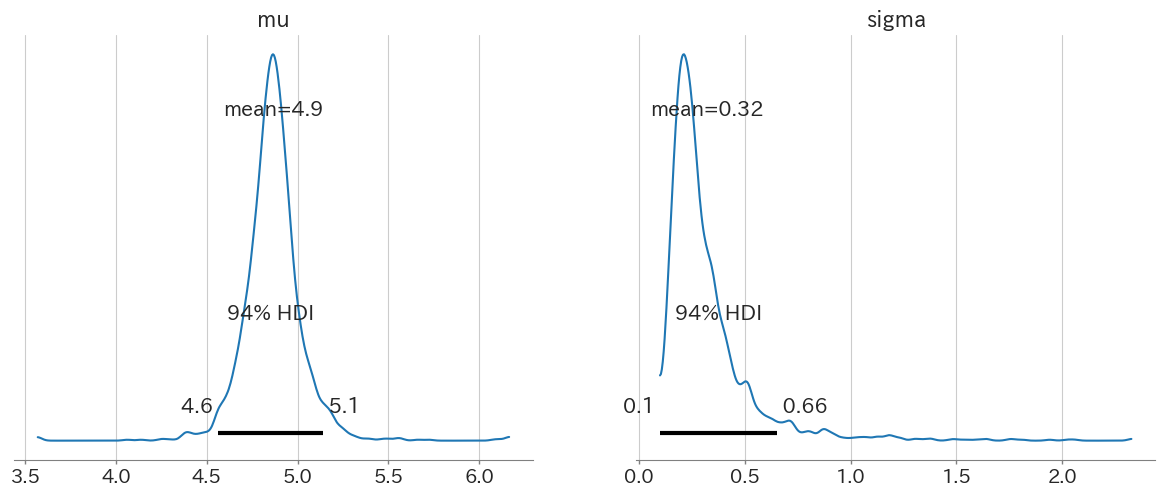

In [20]:
# Sampling結果の可視化
ax = az.plot_posterior(idata_less)

In [21]:
summary_less = az.summary(idata_less)
display(summary_less)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.865,0.164,4.563,5.140,0.007,0.005,680.0,571.0,1.0
sigma,0.321,0.215,0.103,0.655,0.010,0.008,651.0,583.0,1.0


- `mu`, `sigma` とも平均値は Sample数が 50個の場合と大きく変化なし。
- 94%HDI の範囲は広がっており、Data 件数を減らした影響と考えられる。